# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo</h1>

<p style="text-align: center;">Alex Dowling<sup>1,a</sup>, Jacob P. Krell<sup>2</sup>, David S. Mebane<sup>2,b</sup>, Kyla Jones<sup>1</sup></p>

<p style="text-align: center;"><sup>1</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>2</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

<sup>a</sup>adowling@nd.edu <br>
<sup>b</sup>david.mebane@mail.wvu.edu

---

## Abstract

blah

---

## v4

### Nomenclature

- $\mathbf{GP}_{T_i} \equiv$ GP model of $T_i$
- $\mathbf{GP}_{Q_j} \equiv$ GP model of $Q_j$
- $T_i \equiv$ temperature of port $i$
- $Q_i \equiv$ heater power of port $i$
- $t \equiv$ time elapsed since $t_0$, where $T_i(t_0) = T_{i,\text{ref}}$

### Method

$$\tag{1} i, j\ \exist\ [1, 2]$$

$$\tag{1} \mathbf{GP}_{T_i} = \{T_i\ |\ t,\ Q_1,\ Q_2\}$$

$$\tag{1} \mathbf{GP}_{Q_j} = \{Q_j\ |\ t\}$$

$$\tag{1} T_i = f(t, Q_1(t), Q_2(t))$$

$$\tag{1} \frac{dT_i}{dt} = \frac{\partial T_i}{\partial t} + \left(\frac{\partial T_i}{\partial Q_1}\right) \frac{dQ_1}{dt} + \left(\frac{\partial T_i}{\partial Q_2}\right) \frac{dQ_2}{dt}$$


$$\tag{1a} \begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
\tag{1b} C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}$$

#### Goal

The goal then is to model $\frac{dT_{S,i}}{dt}$ directly, i.e., $\frac{dT_i}{dt}$, better than the ODE. The ODE's second equation is then simply replaced by $\frac{dT_i}{dt}$ calculated from the GP.

Or, use only the first ODE equation (since goal is to get $T_H$) where $T_S$, i.e., $T_i$, is calculated directly from the $\mathbf{GP}_{T_i}$.

The question then becomes how to model either $T_i$ or $\frac{dT_i}{dt}$ to best achieve $T_S$, i.e., $T_i$, predictions in the ODE used to obtain $T_H$.

EFFECTIVELY, GP predictions of $T_i$ (no matter how obtained, but constrained to FoKL-GPy methods / chain rule) need to be better than the ODE result which only uses $T_{ref}$. THEN, the GP model may be placed inside the ODE (using only the first equation, or with second too to PROPAGATE $T_S$ if dT is modeled) for the sole sake of obtaining $T_H$.

---

## Two State Model (ODE results for reference, goal is for GP to improve T predictions)

User parameters:

In [1]:
filename = 'tclab_sine_test.csv'

Import modules:

In [2]:
from FoKL import FoKLRoutines
# from FoKL.fokl_to_pyomo import fokl_to_pyomo
import os
dir = os.path.abspath('')  # directory of notebook
# -----------------------------------------------------------------------
# UNCOMMENT IF USING LOCAL FOKL PACKAGE:
import sys
sys.path.append(os.path.join(dir, '..', '..'))  # package directory
from src.FoKL import FoKLRoutines
from src.FoKL.fokl_to_pyomo import fokl_to_pyomo
# -----------------------------------------------------------------------
import numpy as np
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

Load data and plot:

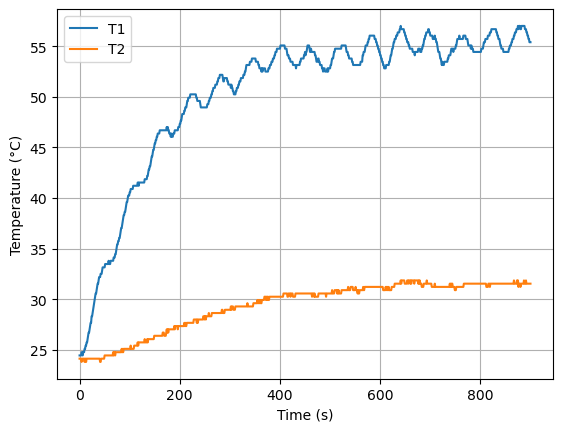

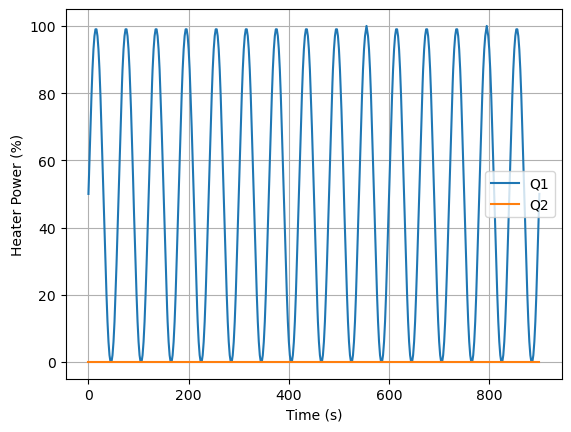

In [3]:
data = pd.read_csv(os.path.join(dir, filename))

data.plot(x='Time', y=['T1', 'T2'], grid=True, xlabel='Time (s)', ylabel='Temperature (°C)')
plt.show()

data.plot(x='Time', y=['Q1', 'Q2'], grid=True, xlabel='Time (s)', ylabel='Heater Power (%)')
plt.show()

Define ODE (Two State Model):

<>:174: SyntaxWarning: invalid escape sequence '\c'
<>:174: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_5136/2078558078.py:174: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("$T_1$ residuals [$^\circ{}$C]",fontsize=fs,fontweight = 'bold')


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8146e+02                                    1.05e+09    
       1              2         2.4374e+02      3.77e+01       4.56e-02       2.21e+07    
       2              3         1.9183e+02      5.19e+01       1.29e-03       1.60e+08    
       3             10         1.9161e+02      2.17e-01       5.94e-06       7.88e+04    
       4             11         1.9079e+02      8.30e-01       4.20e-07       3.37e+07    
`xtol` termination condition is satisfied.
Function evaluations 11, initial cost 2.8146e+02, final cost 1.9079e+02, first-order optimality 3.37e+07.
CpH =  7.006 J/degC
CpS = 0.01 J/degC
Ua =  0.051 W/degC
Ub =  0.001 W/degC


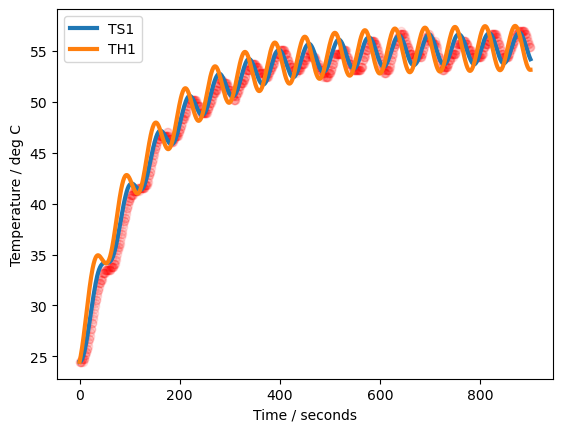

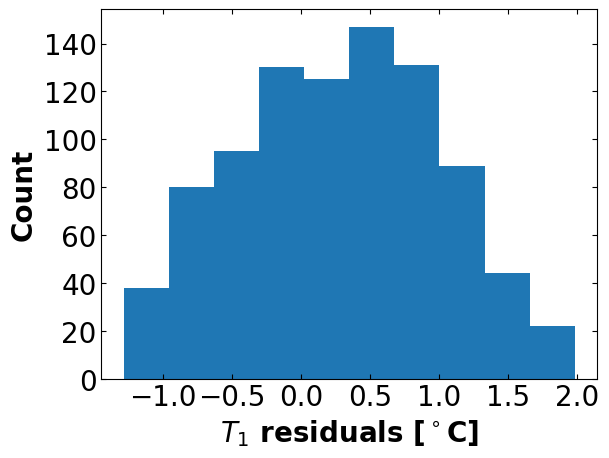

Estimated standard deviation of residuals: 0.771 deg C

Covariance of p = [Ua, Ub, inv_CpH, inv_CpS]
[[ 2.90801047e-09 -3.94220313e-13 -3.58788073e-13 -2.71788410e-07]
 [-3.94220313e-13  6.00932167e-16 -3.15741735e-16  3.67862437e-11]
 [-3.58788073e-13 -3.15741735e-16  3.44082180e-15  3.25470405e-11]
 [-2.71788410e-07  3.67862437e-11  3.25470405e-11  2.54046818e-05]]

Correlation matrix
[[ 1.         -0.29821418 -0.11342504 -0.9999449 ]
 [-0.29821418  1.         -0.21957767  0.29772537]
 [-0.11342504 -0.21957767  1.          0.11008383]
 [-0.9999449   0.29772537  0.11008383  1.        ]]


In [9]:
from scipy.integrate import solve_ivp


# known parameters
T_amb = data["T1"].values[0]    # deg C
alpha = 0.00016                 # watts / (units P1 * percent U1)
P1 = 200                        # P1 units

# adjustable parameters
CpH = 7                         # joules/deg C
CpS = 0.01                      # joules/deg C
Ua = 0.05                       # watts/deg C
Ub = 0.001                      # watts/deg C

# initial conditions
TH1 = T_amb
TS1 = T_amb
IC = [TH1, TS1]

# input values
U1 = lambda t: 50 * np.sin(15 * 2 * np.pi * t / data["Time"].values[-1]) + 50  # U1 == Q1 = f(t), %

def tclab_ode(theta, U1, T_amb, t_expt, return_data_frame=False):
    ''' ODE system for TCLab

    Arguments:
        theta: list fitted parameters CpH, CpS, Ua, Ub
        U1: function that returns the value of U1 at time t
        T_amb: ambient temperature
        t_expt: time values for the experiment

    '''

    # unpack the adjustable parameters
    Ua, Ub, inv_CpH, inv_CpS = theta

    # right hand side of the ODEs
    def deriv(t, y):

        TH1, TS1 = y
        dTH1 = (-Ua*(TH1 - T_amb) + Ub*(TS1 - TH1) + alpha*P1*U1(t))*inv_CpH
        dTS1 = Ub*(TH1 - TS1)*inv_CpS
        return [dTH1, dTS1]

    # define the initial conditions
    IC = [T_amb, T_amb]

    # numerically integrate the ODEs
    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], IC, t_eval=t_expt) 

    if return_data_frame:
        # create dataframe with predictions
        pred = pd.DataFrame(columns=["Time"])
        pred["Time"] = t_expt
        pred = pred.set_index("Time")
        
        # report the model temperatures
        pred["TH1"] = soln.y[0]
        pred["TS1"] = soln.y[1]
        
        # create dataframe with predictions
        pred = pd.DataFrame(columns=["Time"])
        pred["Time"] = t_expt
        pred["TH1"] = soln.y[0]
        pred["TS1"] = soln.y[1]
        pred["Q1"] = U1(t_expt)
            
        return pred
    else:
        return soln.y[1]
    
pred = tclab_ode(theta=[Ua, Ub, 1/CpH, 1/CpS], 
                 U1=U1,
                 T_amb=T_amb,
                 t_expt=data["Time"].values,
                 return_data_frame=True)
pred

from scipy.optimize import least_squares

def covariance_to_correlation(cov):
    ''' Convert covariance matrix into correlation matrix

    Argument:
        cov: covariance matrix

    Returns:
        cor: correlation matrix

    '''

    # Copy matrix
    cor = cov.copy()

    # Get number of rows
    n = cor.shape[0]

    # Loop over rows
    for r in range(n):
        # Loop over columns
        for c in range(n):
            # Scale element
            cor[r,c] = cor[r,c] / np.sqrt(cov[r,r]*cov[c,c])

    return cor

def perform_regression(data, theta_initial=[Ua, Ub, 1/CpH, 1/CpS]):
    ''' Regress the data to find the parameters Ua, Ub, inv_CpH, inv_CpS

    Arguments:
        data: pandas DataFrame with columns "Time", "Q1", "T1", "T2"
        theta_initial: initial guess for the parameters
    '''

    # Interpolate the constrol signal
    U1 = lambda t: np.interp(t, data["Time"], data["Q1"])

    # Calculate the initial conditions
    T_amb = data.T1.values[0]

    # Assemble y data
    y_data = data["T1"].values

    # Define residual function
    def residuals(p):
        pred = tclab_ode(p, 
                         U1,
                         T_amb, 
                         data["Time"].to_numpy(),
                         return_data_frame=False)
        return pred - y_data
    
    # Set bounds for Ua, Ub, inv_CpH, inv_CpS
    # These are based on physical intuition
    bnds = ([1E-5, 1E-5, 1E-2, 1E-2], [2.0, 2.0, 100, 100])
    
    # Perform least squares nonlinear regression
    nl_results = least_squares(residuals, 
                               theta_initial, 
                               bounds=bnds, 
                               method='trf', 
                               verbose=2, 
                               loss="arctan")
    theta_hat = nl_results.x

    # extract and print values
    Ua, Ub, inv_CpH, inv_CpS = nl_results.x
    CpH = 1/inv_CpH
    CpS = 1/inv_CpS

    print('CpH = ', round(CpH,3), "J/degC")
    print('CpS =', round(CpS,3), "J/degC")
    print('Ua = ', round(Ua,3), "W/degC")
    print('Ub = ', round(Ub, 3), "W/degC")

    # plot the results
    pred = tclab_ode([Ua, Ub, inv_CpH, inv_CpS],
                     U1,
                     T_amb,
                     data["Time"].to_numpy(),
                     return_data_frame=True)
    ax = data["T1"].plot(marker='o',color='red', alpha=0.1)
    pred[["TS1", "TH1"]].plot(ax=ax, linewidth=3, xlabel="Time / seconds", ylabel="Temperature / deg C")
    plt.show()

    # plot the residuals
    r = residuals(nl_results.x)

    # define font size
    fs = 20

    # plot data
    plt.hist(r)
    plt.xlabel("$T_1$ residuals [$^\circ{}$C]",fontsize=fs,fontweight = 'bold')
    plt.ylabel("Count",fontsize=fs,fontweight = 'bold')

    # define tick size
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.tick_params(direction="in",top=True, right=True)

    # finish plot
    plt.show()

    # Estimate covariance and correlation of fitted parameters

    #Estimate covariance of residuals
    var_residuals = r.T@r / (len(r) - len(nl_results.x))
    print("Estimated standard deviation of residuals:",round(np.sqrt(var_residuals),3),"deg C")

    # Estimate covariance of fitted parameters
    cov_p = var_residuals * np.linalg.inv(nl_results.jac.T @ nl_results.jac)


    print("\nCovariance of p = [Ua, Ub, inv_CpH, inv_CpS]")
    print(cov_p)

    print("\nCorrelation matrix")
    print(covariance_to_correlation(cov_p))

    return theta_hat, r

    
theta_hat, resid = perform_regression(data=data)


---

## v4a - attempt to better model $T_{1,S}$

Nomenclature:
- $t$
- $T_i \equiv$ surface temperature $T_{S,i}$
- $Q_i$
- $H_i \equiv$ heater temperature $T_{H,i}$

Parsing data:

In [11]:
t = data["Time"].values
T1 = data["T1"].values
T2 = data["T2"].values
Q1 = data["Q1"].values
Q2 = data["Q2"].values

if Q2.min() == Q2.max():
    USE_Q2 = False
else:
    USE_Q2 = True

# From ODE:
T1_ODE = pred["TS1"].values
H1_ODE = pred["TH1"].values

Common functions:

In [12]:
def rmse(targets, predictions):
    return np.sqrt(np.mean((predictions - targets) ** 2))

### T

- ```GPT1``` $\equiv \mathbf{GP}_{T_1}$
- ```T1_GPT1``` $\equiv T_{1,\mathbf{GP}_{T_1}} \equiv$ predictions of $T_1$ made with $\mathbf{GP}_{T_1}$

In [13]:
if USE_Q2 is True:
    GPT1 = FoKLRoutines.FoKL(kernel=1, way3=True)
    GPT1.fit([t, Q1, Q2], T1, clean=True, pillow=[[0, 0.2], [0, 0], [0, 0]])
else:
    GPT1 = FoKLRoutines.FoKL(kernel=1)
    GPT1.fit([t, Q1], T1, clean=True, pillow=[[0, 0.2], [0, 0], [0, 0]])

/home/jacobpatrick/ESMS/support/FoKL-GPy-tclab_v4/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:290: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, 3592.1272475128376]
[2, 3587.245251431803]
[2, 2325.6195698812176]
[3, 2307.576809156444]
[3, 574.1060402705098]
[4, 574.1060402705098]
[4, 541.0227523695313]
[4, -331.6304545994731]
[5, -331.6304545994731]
[5, -331.6304545994731]
[5, -384.5278772772511]
[6, -384.5278772772511]
[6, -379.81899030224395]
[6, -382.6726976675709]


Get predictions and RMSE of $\mathbf{GP}_{T_1}$.

RMSE of ODE  = 1.2794002395985897
RMSE of GPT1 = 0.47058605938490217


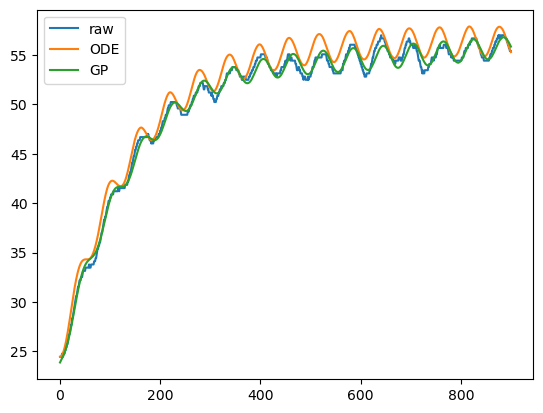

In [16]:
T1_GPT1 = GPT1.evaluate()

RMSE_ODE = rmse(T1, T1_ODE)
RMSE_GPT1 = rmse(T1, T1_GPT1)
print(f"RMSE of ODE  = {RMSE_ODE}")
print(f"RMSE of GPT1 = {RMSE_GPT1}")

# -----------------------------------

plt.plot(t, T1)
plt.plot(t, T1_ODE)  # RTW --- NEEDS TO ALIGN (MAYBE INTERPOLATE) WITH t .... WHY DOES ODE CHANGE TIME STEPS ?
plt.plot(t, T1_GPT1)

_ = plt.legend(["raw", "ODE", "GP"])

### dT via chain rule of T

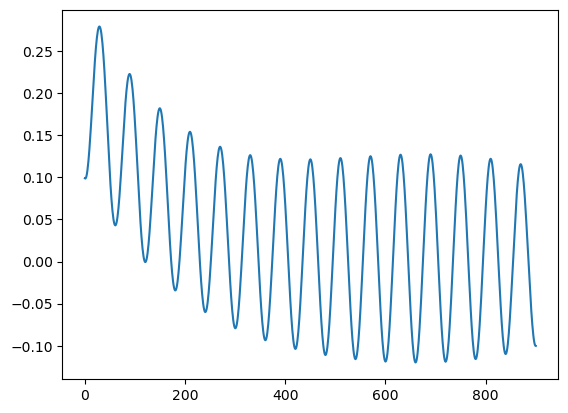

In [25]:
dQ1dt = lambda tvar: 50 * np.cos(15 * 2 * np.pi * tvar / t[-1]) * 15 * 2 * np.pi / t[-1]
dQ1dt = dQ1dt(t)

dT1_GPT1 = GPT1.bss_derivatives()
dT1dt_GPT1 = dT1_GPT1[:, 0]
dT1dQ1_GPT1 = dT1_GPT1[:, 1]

if USE_Q2 is True:
    dQ2dt = 0
    dT1dQ2_GPT1 = dT1_GPT1[:, 2]
    dT1dt = dT1dt_GPT1 + dT1dQ1_GPT1 * dQ1dt + dT1dQ2_GPT1 * dQ2dt
else:
    dT1dt = dT1dt_GPT1 + dT1dQ1_GPT1 * dQ1dt

### dT via smoothing and numeric differentiation

### T as integral of dT from smoothing and numeric differentiation

---

#### What to do with $T_H$ in order to gauge accuracy of model

pyomo stuff / optimal control

## References

### [ode45](https://www.mathworks.com/help/matlab/ref/ode45.html#bu00_4l_sep_shared-odefun):

Inputs: 
- $(y_1, y_2)_{t_0}$
- $y'_1 = y_1 + 2y_2$
- $y'_2 = 3y_1 + 2y_2$

Output:
- $(y_1, y_2)_t$

### TCLab

- [linear ODE model](https://ndcbe.github.io/controls/notebooks/02.05-Second-Order.html)
- [predictive control using ODE (Optimization-Estimation-Control)](https://ndcbe.github.io/controls/notebooks/07-TCLab-Optimization-Estimation-Control.html)
- [predictive control using ODE (Model-Predictive-Control)](https://ndcbe.github.io/controls/notebooks/06-TCLab-Model-Predictive-Control.html)
- [workshop tutorial on model-based design of experiments](https://dowlinglab.github.io/pyomo-doe/Readme.html)